In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from solver import deasolver

In [6]:
results = []
df_imp = pd.DataFrame()

In [90]:
path = "Data/RealData/Simulation/"

In [91]:
df = pd.read_excel(path + 'df51.xlsx', index_col = 0)

In [92]:
df

,Input 1,Input 2,Input 3,Input 4,Input 5,Output
DMU 0001,297.05,278.35,610.26,346.60,359.56,1142.429694
DMU 0002,726.55,170.31,295.74,417.47,403.38,1240.585759
DMU 0003,289.29,369.62,586.33,275.17,380.85,1519.009699
DMU 0004,560.78,259.74,372.31,334.00,419.41,1394.024111
DMU 0005,620.35,285.85,404.26,458.16,334.64,1693.505421
...,...,...,...,...,...,...
DMU 0996,360.84,159.65,684.56,410.24,375.58,744.446355
DMU 0997,627.54,303.87,326.63,440.97,333.79,1720.904676
DMU 0998,372.33,297.94,620.79,374.65,397.02,1261.041060
DMU 0999,574.33,356.52,471.89,391.15,361.48,1500.422656


In [93]:
deasolver(inputfile = path + 'df51.xlsx', folder = path, out_suffix1="_Sol")

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [94]:
df_weights = pd.read_excel(path + "df51_Sol.xlsx", index_col = 0).iloc[:, 1:]
df_weights

,Weight_Input 1,Weight_Input 2,Weight_Input 3,Weight_Input 4,Weight_Input 5,Weight_Output
DMU 0001,0.002404,0.000909,0.000054,0.000000,0.000000,0.000699
DMU 0002,0.000000,0.004289,0.000911,0.000000,0.000000,0.000721
DMU 0003,0.002139,0.000826,0.000129,0.000000,0.000000,0.000658
DMU 0004,0.000605,0.001693,0.000110,0.000539,0.000000,0.000592
DMU 0005,0.000538,0.001432,0.000118,0.000000,0.000626,0.000549
...,...,...,...,...,...,...
DMU 0996,0.001250,0.003438,0.000000,0.000000,0.000000,0.000866
DMU 0997,0.000230,0.001432,0.000434,0.000000,0.000836,0.000551
DMU 0998,0.000991,0.001173,0.000454,0.000000,0.000000,0.000601
DMU 0999,0.000626,0.000960,0.000364,0.000024,0.000323,0.000506


In [95]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input 1    101
Weight_Input 2     26
Weight_Input 3    522
Weight_Input 4    401
Weight_Input 5    299
Weight_Output       0
dtype: int64

In [96]:
df_zero = (((df_weights==0).sum() / df_weights.shape[0]) * 100).round(2)
df_zero

Weight_Input 1    10.1
Weight_Input 2     2.6
Weight_Input 3    52.2
Weight_Input 4    40.1
Weight_Input 5    29.9
Weight_Output      0.0
dtype: float64

### ML

In [97]:
X = df.iloc[:,:-1]
X.head()

,Input 1,Input 2,Input 3,Input 4,Input 5
DMU 0001,297.05,278.35,610.26,346.60,359.56
DMU 0002,726.55,170.31,295.74,417.47,403.38
DMU 0003,289.29,369.62,586.33,275.17,380.85
DMU 0004,560.78,259.74,372.31,334.00,419.41
DMU 0005,620.35,285.85,404.26,458.16,334.64


In [98]:
X.shape

(1000, 5)

In [99]:
y = df.iloc[:,-1:]
y.head()

,Output
DMU 0001,1142.429694
DMU 0002,1240.585759
DMU 0003,1519.009699
DMU 0004,1394.024111
DMU 0005,1693.505421


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
std_scaler = StandardScaler()

In [102]:
gb_model = GradientBoostingRegressor(random_state=0)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -11619.483447219862
neg_root_mean_squared_error: -107.69772386329119
r2: 0.7852676093820508


In [103]:
learning_rate = [1, 0.1,  0.01]
n_estimators = [50, 100, 200]
max_depth = [3, 5, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 1.0]

In [104]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [105]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="r2")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=0))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 None],
                                        'gradientboostingregressor__min_samples_leaf': [1,
                                                                                        2,
                                                                                        4],
                                        'gradientboostingregressor__min_samples_split': [2,
                                                                                         5,
                                                                                         10],
                                        'gradientboostingregressor__n_estimators': [50,
                                                                                    100,
                                                                                    200],
                                        'gradientboostingregressor__subsample': [0.3,
                                                                                 0.5,
                                                                                 1.0]},
                   scoring='r2')

In [106]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
#print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

0.7881634372043548
{'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 50, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(min_samples_leaf=4,
                                           min_samples_split=10,
                                           n_estimators=50, random_state=0,
                                           subsample=0.5))])


In [107]:
grid.best_estimator_.score(X,y)

0.8434985055082708

In [108]:
pickle.dump(grid, open("Data/RealData/Simulation/grid_51.pkl", 'wb'))

In [109]:
grid = pickle.load(open("Data/RealData/Simulation/grid_51.pkl", 'rb'))

In [82]:
#pipe_gb.fit(X,y.values.ravel())

In [83]:
# imp_gb = pipe_gb.steps[1][1].feature_importances_
# imp_gb

In [110]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.28, 0.68, 0.02, 0.01, 0.01])

In [111]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
1,Input 2,0.680965
0,Input 1,0.281513
2,Input 3,0.017150
4,Input 5,0.011262
3,Input 4,0.009109


In [112]:
results = []

In [113]:
input_imp = list(df_gb["Feature Name"].values)
results.append((0, grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

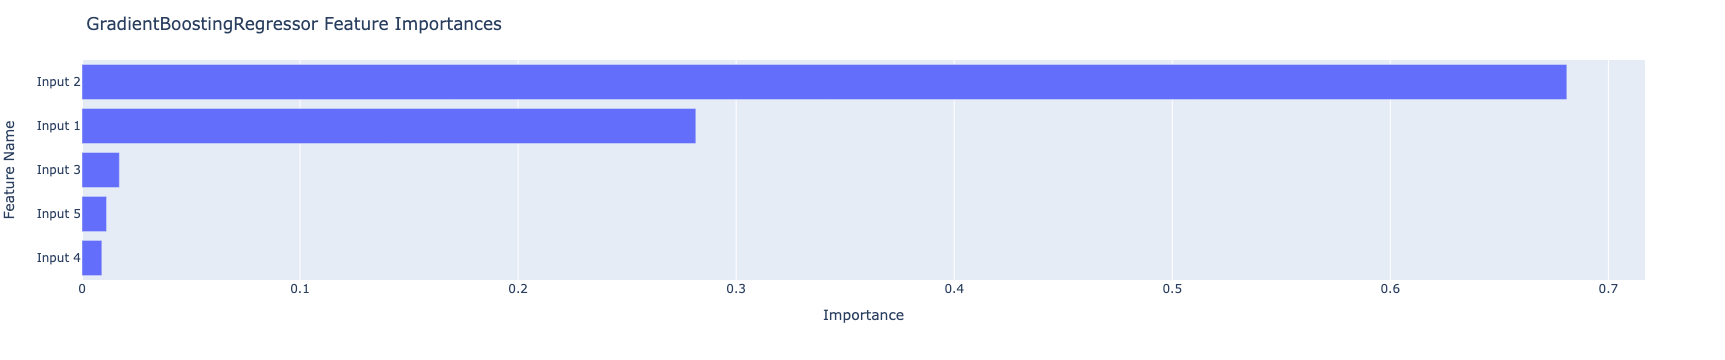

In [114]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=600,
    height=300,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [115]:
df_gb

,Feature Name,Importance
1,Input 2,0.680965
0,Input 1,0.281513
2,Input 3,0.017150
4,Input 5,0.011262
3,Input 4,0.009109


In [116]:
df_zero.index = ["_".join(f.split("_")[1:]) for f in df_zero.index]

In [117]:
df_zero

Input 1    10.1
Input 2     2.6
Input 3    52.2
Input 4    40.1
Input 5    29.9
Output      0.0
dtype: float64

In [118]:
df_zero.reset_index()

,index,0
0,Input 1,10.1
1,Input 2,2.6
2,Input 3,52.2
3,Input 4,40.1
4,Input 5,29.9
5,Output,0.0


In [119]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Input 2,0.680965,Input 2,2.6
1,Input 1,0.281513,Input 1,10.1
2,Input 3,0.017150,Input 3,52.2
3,Input 5,0.011262,Input 5,29.9
4,Input 4,0.009109,Input 4,40.1


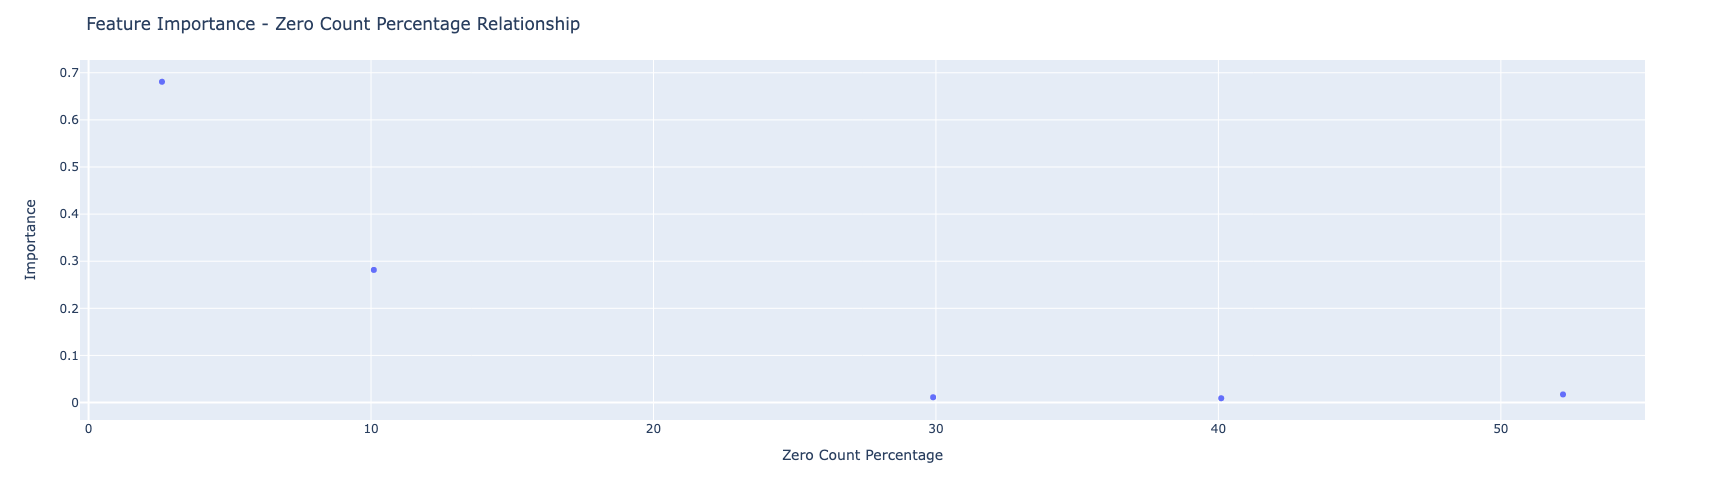

In [120]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Feature Importance - Zero Count Percentage Relationship",
     xaxis_title="Zero Count Percentage"
)

fig.show()

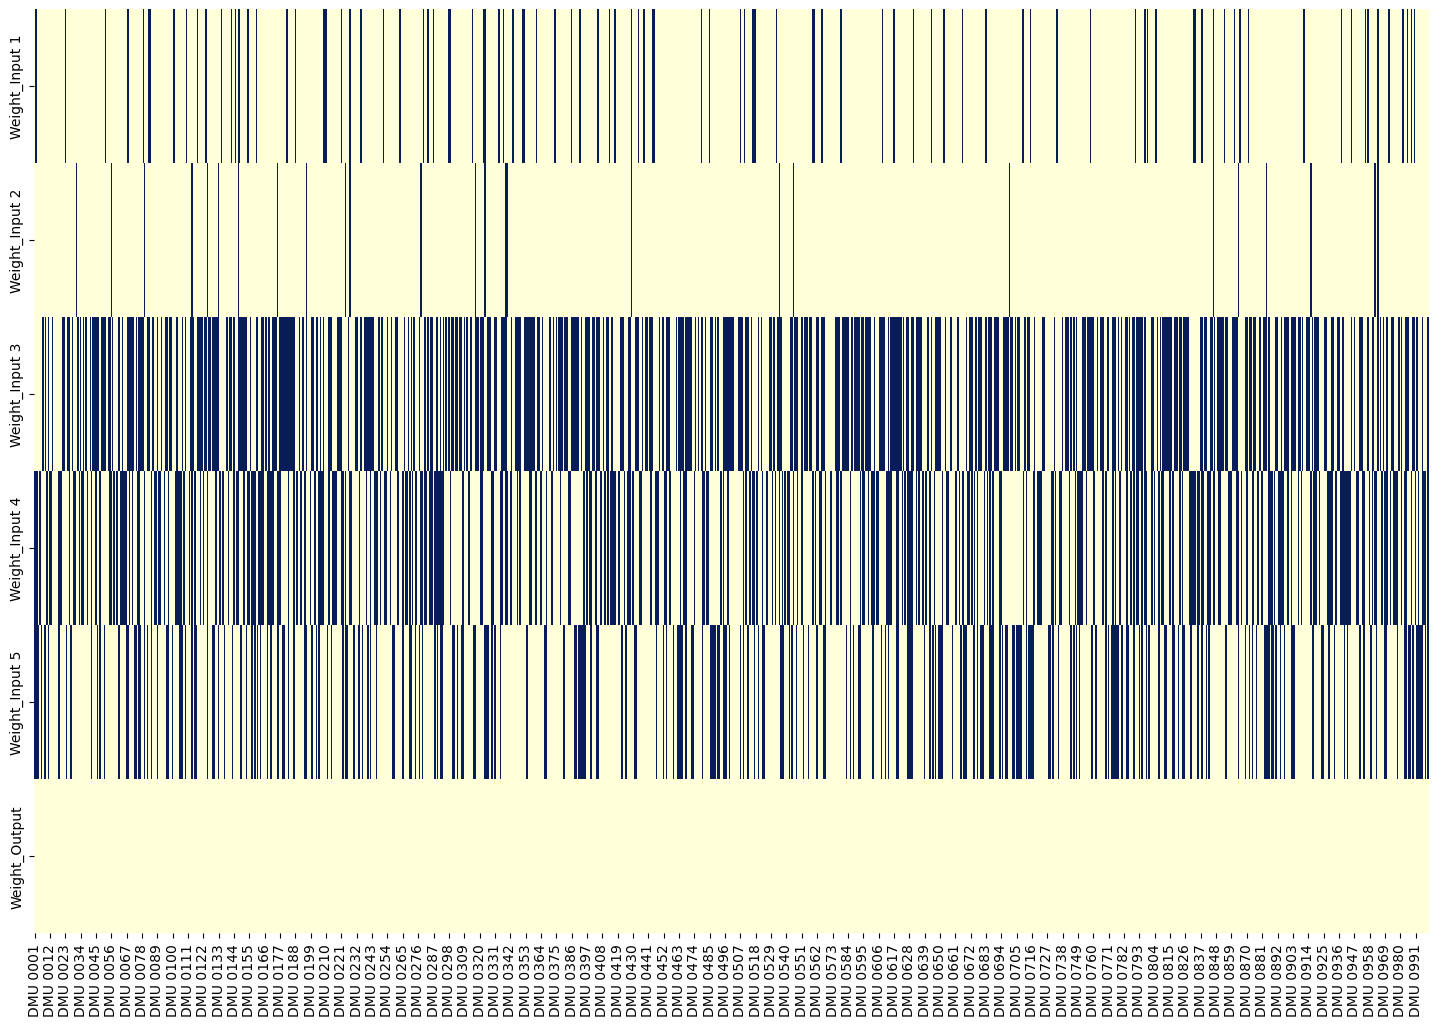

In [121]:
plt.figure(figsize=(18,12))
sns.heatmap(df_weights.eq(0).transpose(),
        cmap="YlGnBu",
        cbar=False,
        cbar_kws={'label': 'Zero Values'});

In [122]:
results 

[(0,
  'gradientboostingregressor',
  ['Input 2', 'Input 1', 'Input 3', 'Input 5', 'Input 4'],
  {'r2': 0.7881634372043548,
   'neg_root_mean_squared_error': 0.7881634372043548})]

In [123]:
deasolver(inputfile = path + 'df51.xlsx', folder = path, out_suffix1="_Sol_1", input_imp = results[0])

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [124]:
df_weights_1 = pd.read_excel( path + "df51_Sol_1.xlsx", index_col = 0).iloc[:, 1:]
df_weights_1

,Weight_Input 1,Weight_Input 2,Weight_Input 3,Weight_Input 4,Weight_Input 5,Weight_Output
DMU 0001,0.001738,0.001738,0.000000,0.000000,0.000000,0.000677
DMU 0002,0.000262,0.003515,0.000262,0.000066,0.000262,0.000668
DMU 0003,0.001136,0.001136,0.000429,0.000000,0.000000,0.000616
DMU 0004,0.000724,0.001270,0.000286,0.000209,0.000209,0.000585
DMU 0005,0.000682,0.001062,0.000370,0.000000,0.000370,0.000546
...,...,...,...,...,...,...
DMU 0996,0.001250,0.003438,0.000000,0.000000,0.000000,0.000866
DMU 0997,0.000640,0.001080,0.000409,0.000000,0.000409,0.000550
DMU 0998,0.000991,0.001173,0.000454,0.000000,0.000000,0.000601
DMU 0999,0.000626,0.000960,0.000364,0.000024,0.000323,0.000506


In [125]:
df_es = pd.read_excel(path + "df51_Sol.xlsx", index_col = 0).iloc[:, :1]
df_es_1 = pd.read_excel(path + "df51_Sol_1.xlsx", index_col = 0).iloc[:, :1]

In [126]:
es = (df_es.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es}")

count of efficient units : 24


In [127]:
es_1 = (df_es_1.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es_1}")

count of efficient units : 6


In [128]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input 1    101
Weight_Input 2     26
Weight_Input 3    522
Weight_Input 4    401
Weight_Input 5    299
Weight_Output       0
dtype: int64

In [129]:
df_zero_1 =(df_weights_1==0).sum()
df_zero_1

Weight_Input 1      2
Weight_Input 2      0
Weight_Input 3     76
Weight_Input 4    549
Weight_Input 5    234
Weight_Output       0
dtype: int64

In [130]:
df_zero_1_perc = (((df_weights_1==0).sum() / df_weights_1.shape[0]) * 100).round(2)
df_zero_1_perc

Weight_Input 1     0.2
Weight_Input 2     0.0
Weight_Input 3     7.6
Weight_Input 4    54.9
Weight_Input 5    23.4
Weight_Output      0.0
dtype: float64

In [131]:
df_es

,Efficiency_Scores
DMU 0001,0.799093
DMU 0002,0.895046
DMU 0003,1.000000
DMU 0004,0.824928
DMU 0005,0.929981
...,...
DMU 0996,0.644497
DMU 0997,0.947669
DMU 0998,0.757796
DMU 0999,0.759479


In [132]:
df_es_1

,Efficiency_Scores
DMU 0001,0.773426
DMU 0002,0.828927
DMU 0003,0.935628
DMU 0004,0.814843
DMU 0005,0.923910
...,...
DMU 0996,0.644497
DMU 0997,0.946066
DMU 0998,0.757796
DMU 0999,0.759479


In [133]:
df_res = df_es.join(df_es_1, lsuffix = "_Basic", rsuffix="_with_ML")

In [134]:
df_res["Diff"] = df_res["Efficiency_Scores_Basic"]  - df_res["Efficiency_Scores_with_ML"]
df_res["Diff_Perc"] = (df_res["Diff"] / df_res["Efficiency_Scores_Basic"]) * 100 
df_res["Diff_Perc < 10"] = np.abs(df_res["Diff_Perc"]) < 10  
df_res = df_res.round(4)
df_res

,Efficiency_Scores_Basic,Efficiency_Scores_with_ML,Diff,Diff_Perc,Diff_Perc < 10
DMU 0001,0.7991,0.7734,0.0257,3.2120,True
DMU 0002,0.8950,0.8289,0.0661,7.3873,True
DMU 0003,1.0000,0.9356,0.0644,6.4372,True
DMU 0004,0.8249,0.8148,0.0101,1.2225,True
DMU 0005,0.9300,0.9239,0.0061,0.6528,True
...,...,...,...,...,...
DMU 0996,0.6445,0.6445,0.0000,0.0000,True
DMU 0997,0.9477,0.9461,0.0016,0.1691,True
DMU 0998,0.7578,0.7578,0.0000,0.0000,True
DMU 0999,0.7595,0.7595,0.0000,0.0000,True


In [135]:
blue = df_res["Diff_Perc < 10"].sum()
print("blue : ", blue)
red = len(df_res["Diff_Perc < 10"]) - (df_res["Diff_Perc < 10"].sum())
print("red : ", red)

blue :  991
red :  9


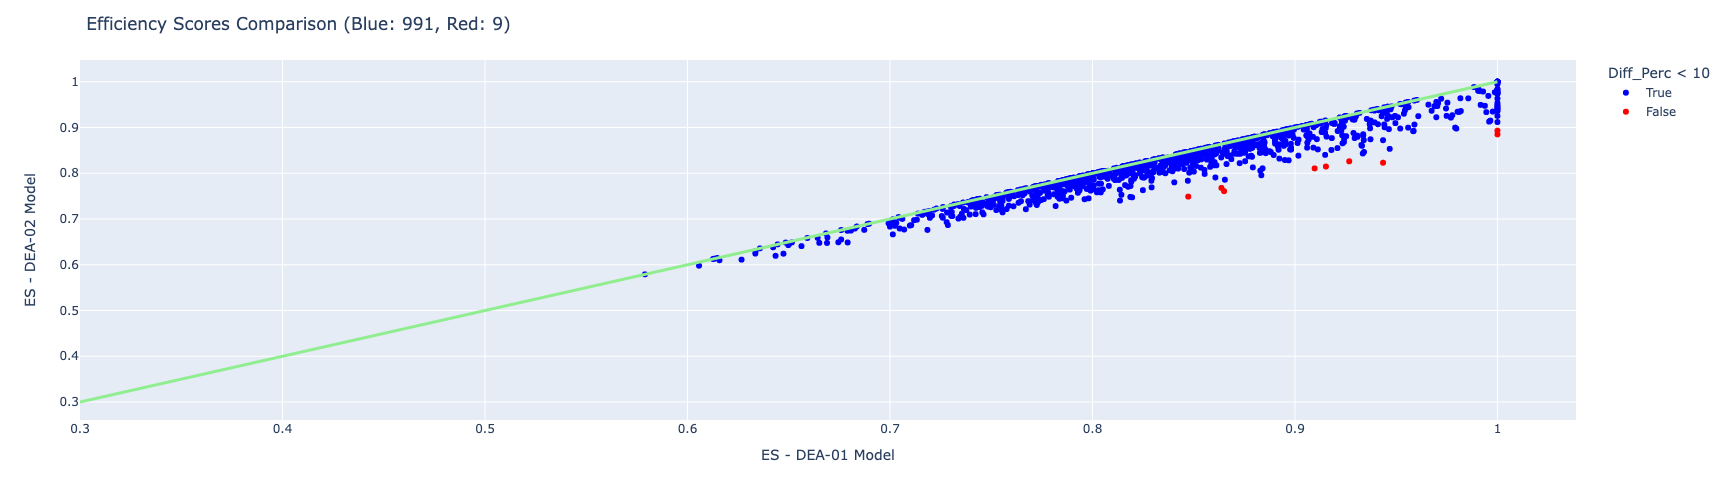

In [136]:
fig = px.scatter(df_res, x="Efficiency_Scores_Basic", y="Efficiency_Scores_with_ML", color = "Diff_Perc < 10", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Efficiency_Scores_Basic", "Efficiency_Scores_with_ML", "Diff_Perc"] + [df_res.index])

fig.add_traces(
    list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
)

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison (Blue: {blue}, Red: {red})",
    yaxis_title="ES - DEA-02 Model",
    xaxis_title="ES - DEA-01 Model"
)

fig.show()

In [137]:
colors = np.linspace(0.2, 1, len(df_res))

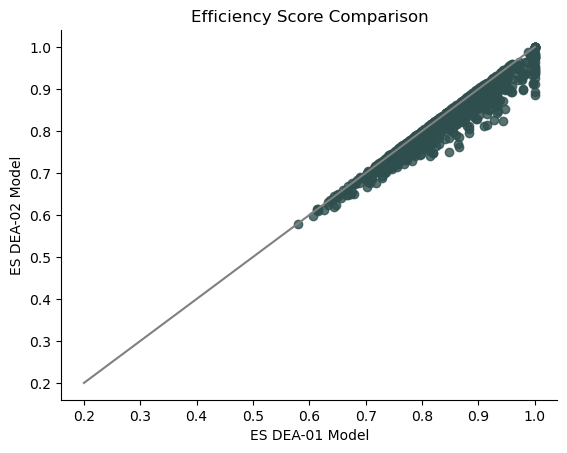

In [138]:
# Show the boundary between the regions:
# theta = np.arange(0, np.pi / 2, 0.01)
# plt.plot(r0 * np.cos(theta), r0 * np.sin(theta))
# colors = np.arange(0, 1, len(df_res))
# Hide the upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.scatter(df_res["Efficiency_Scores_Basic"], y = df_res["Efficiency_Scores_with_ML"], c = "darkslategray", alpha = 0.8)

x_line = np.linspace(0.2, 1, 10)
y_line = x_line
plt.plot(x_line, y_line, color='gray')


plt.xlabel("ES DEA-01 Model")
plt.ylabel("ES DEA-02 Model")
plt.title("Efficiency Score Comparison")
plt.savefig("Viz/ES Comparison.png")

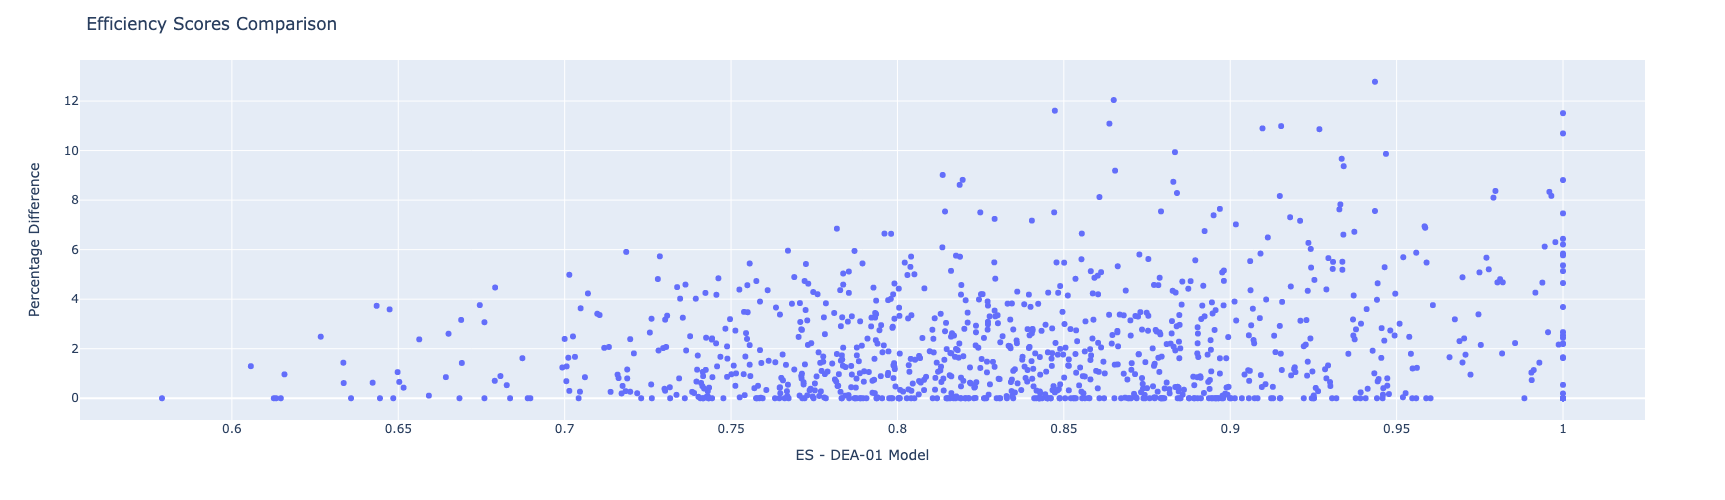

In [139]:
fig = px.scatter(df_res, x="Efficiency_Scores_Basic", y="Diff_Perc",
                 hover_data=["Efficiency_Scores_Basic", "Efficiency_Scores_with_ML", "Diff_Perc"] + [df_res.index])

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison",
    xaxis_title="ES - DEA-01 Model",
    yaxis_title="Percentage Difference"
)

fig.show()

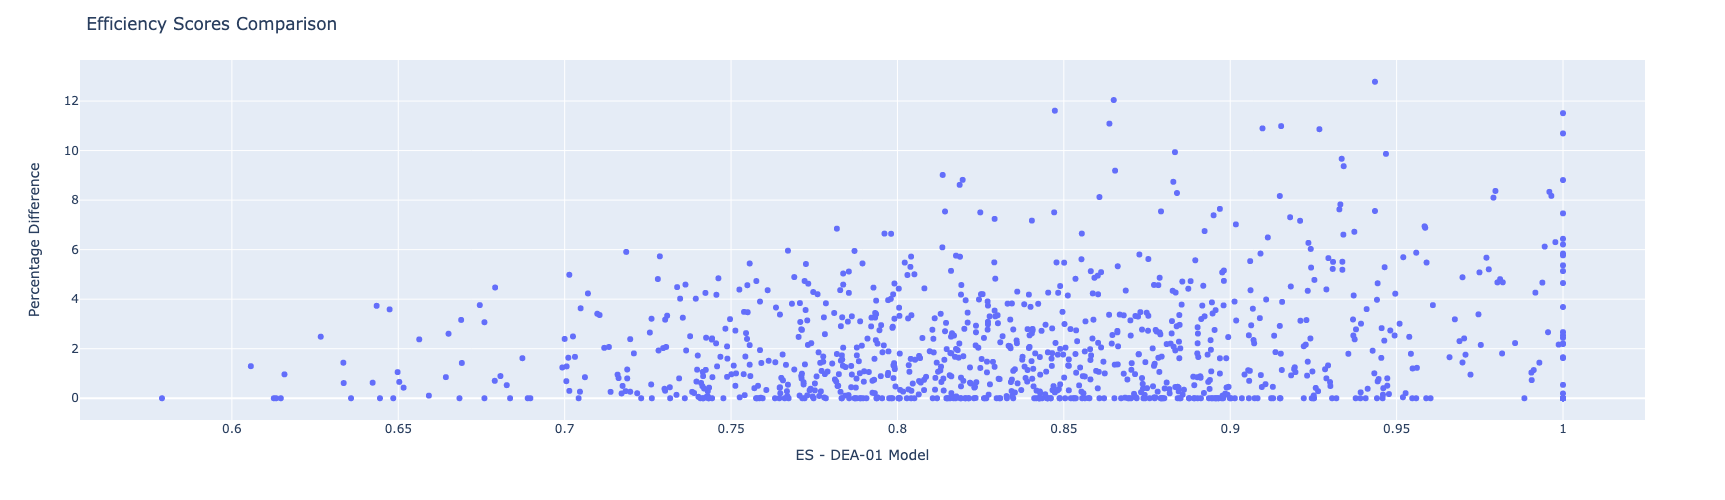

In [140]:
fig = px.scatter(df_res, x="Efficiency_Scores_Basic", y="Diff_Perc",
                 hover_data=["Efficiency_Scores_Basic", "Diff_Perc"] + [df_res.index])

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison",
    xaxis_title="ES - DEA-01 Model",
    yaxis_title="Percentage Difference"
)

fig.show()

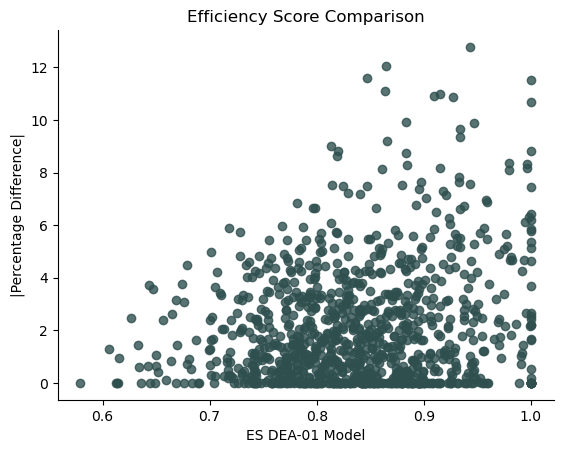

In [141]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.scatter(df_res["Efficiency_Scores_Basic"], y = df_res["Diff_Perc"], c = "darkslategray", alpha = 0.8)

plt.xlabel("ES DEA-01 Model")
plt.ylabel("|Percentage Difference|")
plt.title("Efficiency Score Comparison")
plt.savefig("Viz/ES Comparison_1.png")

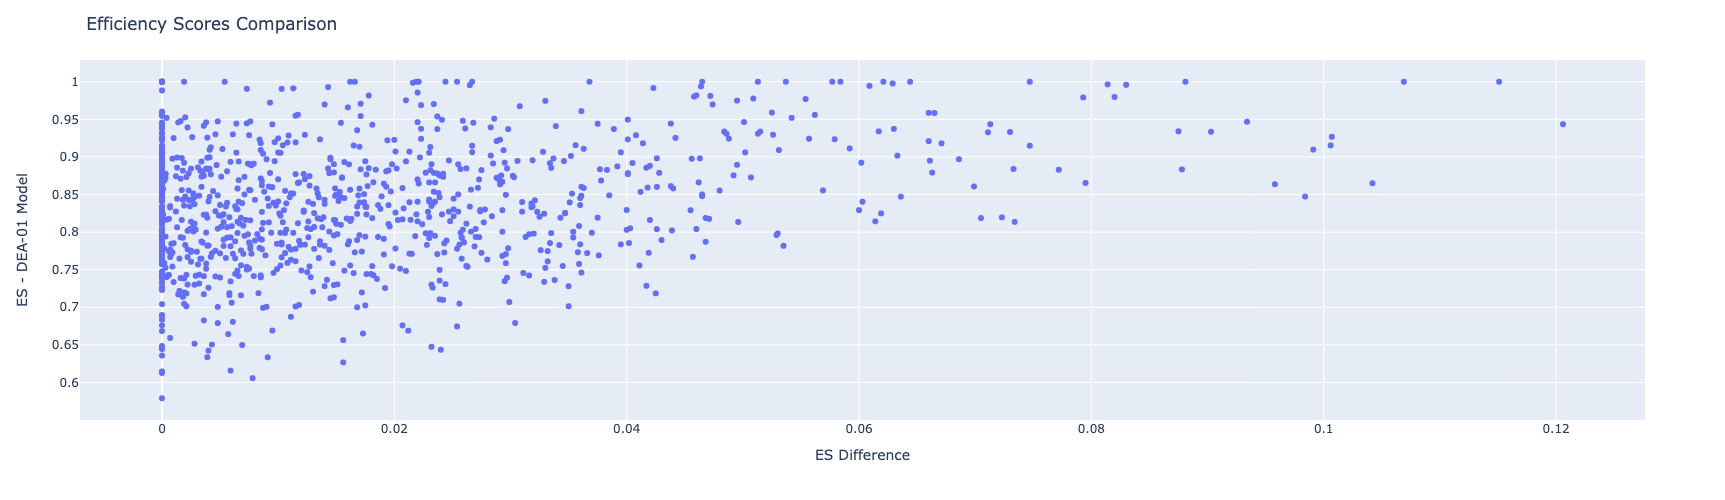

In [142]:
fig = px.scatter(df_res, y="Efficiency_Scores_Basic", x="Diff",
                 hover_data=["Efficiency_Scores_Basic", "Diff"] + [df_res.index])

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison",
    yaxis_title="ES - DEA-01 Model",
    xaxis_title="ES Difference"
)

fig.show()

In [143]:
df_w = (df_weights.iloc[:, :-1] == 0).sum(axis=1).reset_index()
df_w.columns = ["DMU", "DEA-01 Zero Count"]
df_w

,DMU,DEA-01 Zero Count
0,DMU 0001,2
1,DMU 0002,3
2,DMU 0003,2
3,DMU 0004,1
4,DMU 0005,1
...,...,...
995,DMU 0996,3
996,DMU 0997,1
997,DMU 0998,2
998,DMU 0999,0


In [144]:
df_w1 = (df_weights_1.iloc[:, :-1] == 0).sum(axis=1).reset_index()
df_w1.columns = ["DMU", "DEA-02 Zero Count"]
df_w1

,DMU,DEA-02 Zero Count
0,DMU 0001,3
1,DMU 0002,0
2,DMU 0003,2
3,DMU 0004,0
4,DMU 0005,1
...,...,...
995,DMU 0996,3
996,DMU 0997,1
997,DMU 0998,2
998,DMU 0999,0


In [145]:
df_w_merged = df_w.merge(df_w1)

In [146]:
df_w_merged

,DMU,DEA-01 Zero Count,DEA-02 Zero Count
0,DMU 0001,2,3
1,DMU 0002,3,0
2,DMU 0003,2,2
3,DMU 0004,1,0
4,DMU 0005,1,1
...,...,...,...
995,DMU 0996,3,3
996,DMU 0997,1,1
997,DMU 0998,2,2
998,DMU 0999,0,0


In [147]:
df_w_merged[df_w_merged["DEA-01 Zero Count"] > df_w_merged["DEA-02 Zero Count"]].shape

(477, 3)

In [148]:
df_w_merged[df_w_merged["DEA-01 Zero Count"] == df_w_merged["DEA-02 Zero Count"]].shape

(413, 3)

In [149]:
df_w_merged[df_w_merged["DEA-01 Zero Count"] < df_w_merged["DEA-02 Zero Count"]].shape

(110, 3)

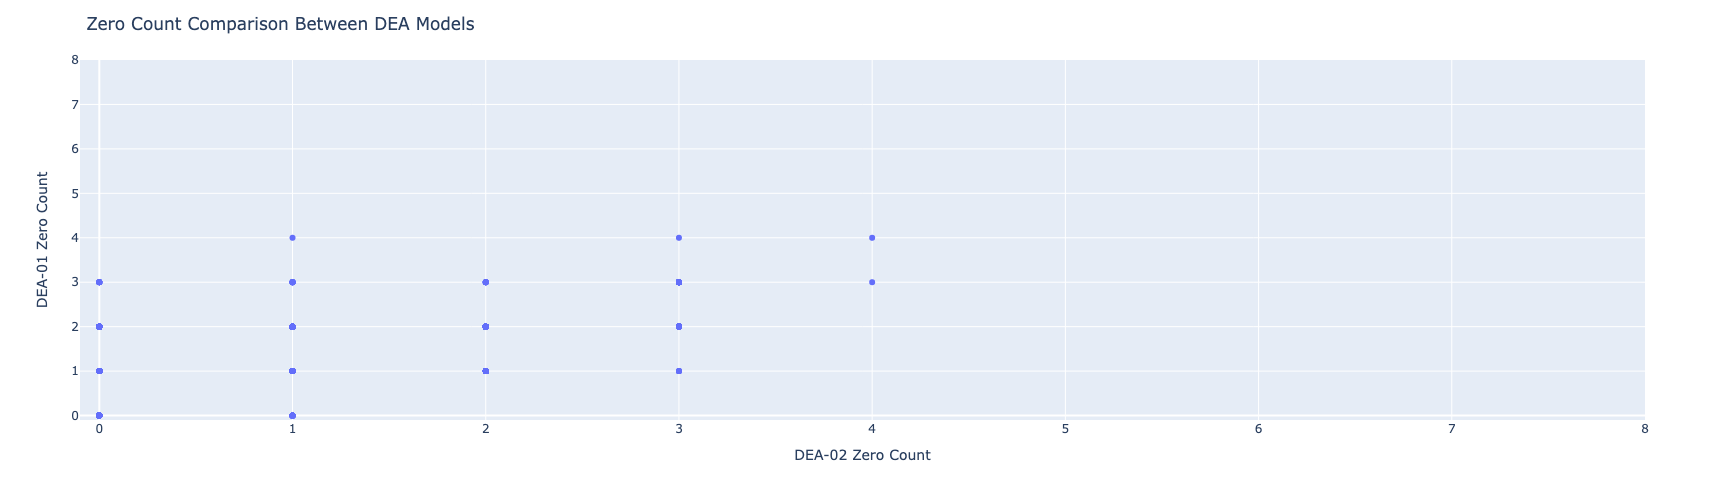

In [150]:
fig = px.scatter(df_w_merged, x="DEA-02 Zero Count", y="DEA-01 Zero Count")

# fig.add_traces(
#     list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
# )

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Zero Count Comparison Between DEA Models",
    yaxis_range = [-0.1,8],
    xaxis_range = [-0.1,8],
#    xaxis_title="ES - 2nd DEA Model",
#    yaxis_title="ES - 1st DEA Model"
)

fig.show()

In [151]:
df_w_merged_gr = df_w_merged.groupby(["DEA-02 Zero Count", "DEA-01 Zero Count"], as_index = False).size()
df_w_merged_gr

,DEA-02 Zero Count,DEA-01 Zero Count,size
0,0,0,71
1,0,1,273
2,0,2,99
3,0,3,8
4,1,0,18
...,...,...,...
13,3,2,40
14,3,3,29
15,3,4,1
16,4,3,1


In [152]:
df_w_merged_gr["size"] = df_w_merged_gr["size"] + 20

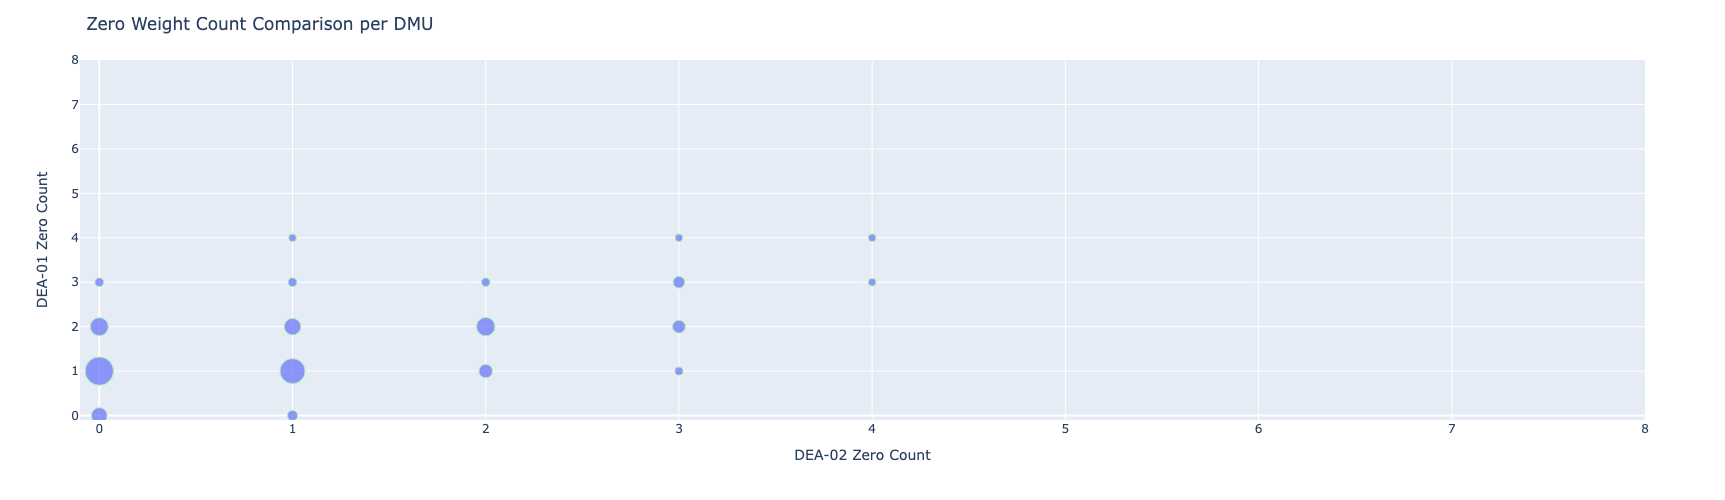

In [153]:
fig = px.scatter(df_w_merged_gr, x="DEA-02 Zero Count", y="DEA-01 Zero Count", size = "size")

# fig.add_traces(
#     list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
# )

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Zero Weight Count Comparison per DMU",
    yaxis_range = [-0.1,8],
    xaxis_range = [-0.1,8],
#    xaxis_title="ES - 2nd DEA Model",
#    yaxis_title="ES - 1st DEA Model"
)

fig.show()

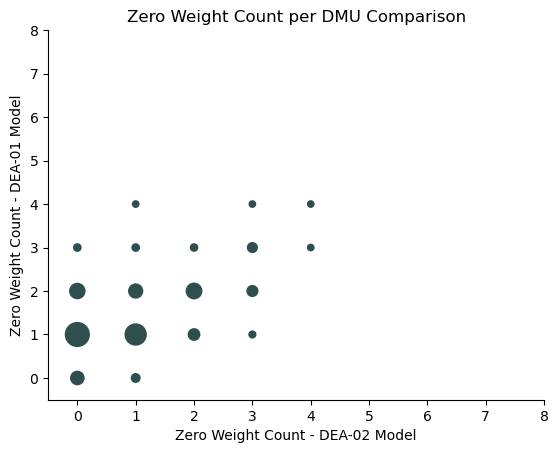

In [154]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.scatter(x = df_w_merged_gr["DEA-02 Zero Count"], y = df_w_merged_gr["DEA-01 Zero Count"], s = df_w_merged_gr["size"], c = "darkslategray")

# Set the x-axis range
plt.ylim(-0.5, 8)
plt.xlim(-0.5, 8)

plt.xlabel("Zero Weight Count - DEA-02 Model")
plt.ylabel("Zero Weight Count - DEA-01 Model")
plt.title("Zero Weight Count per DMU Comparison")
plt.savefig("Viz/Zero Weight Comparison.png")

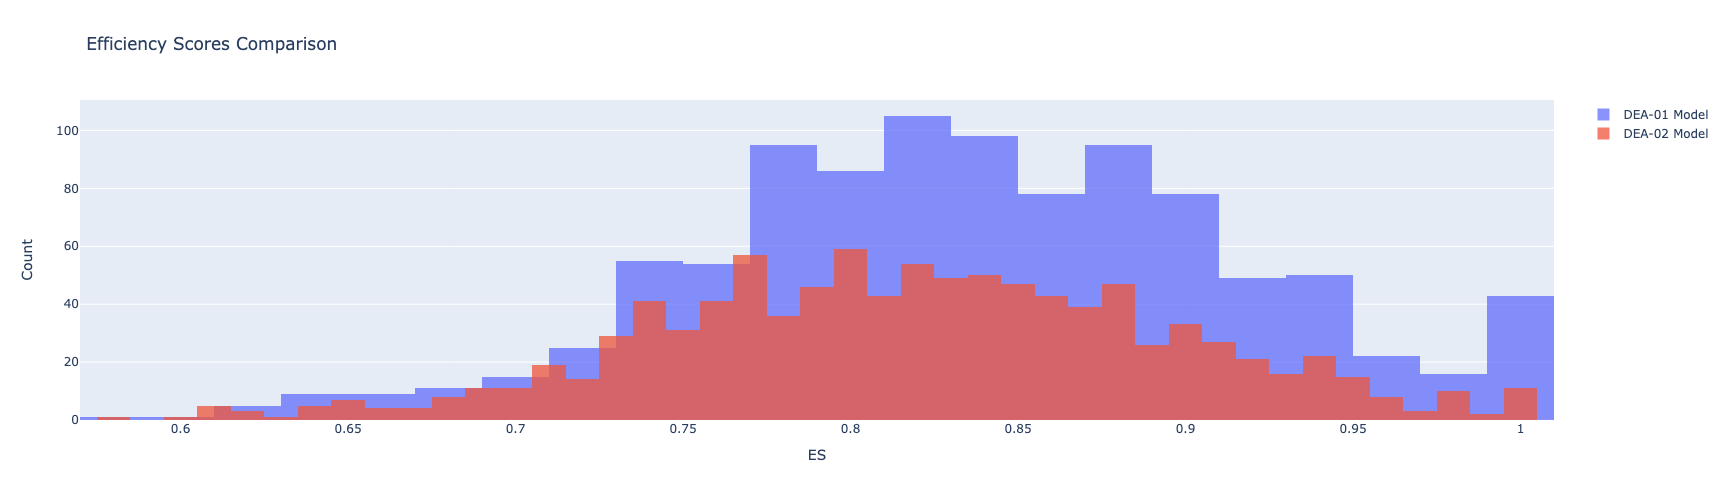

In [155]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_res["Efficiency_Scores_Basic"], name= "DEA-01 Model"))
fig.add_trace(go.Histogram(x=df_res["Efficiency_Scores_with_ML"], name= "DEA-02 Model"))

# Overlay both histograms
fig.update_layout(barmode='overlay')

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison",
    yaxis_title="Count",
    xaxis_title="ES"
)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

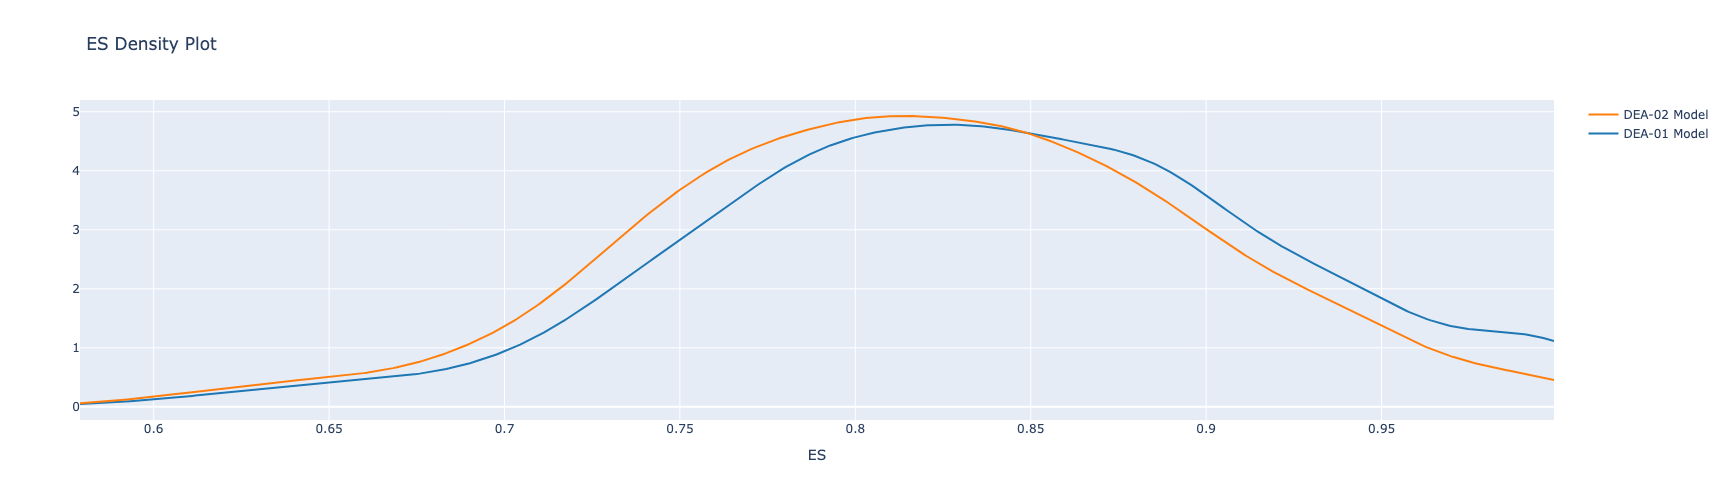

In [156]:
hist_data = [df_res["Efficiency_Scores_Basic"], df_res["Efficiency_Scores_with_ML"]]

group_labels = ['DEA-01 Model', 'DEA-02 Model']
colors = ['#333F44', '#37AA9C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False,  show_rug=False)

# Add title
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"ES Density Plot",
    #yaxis_title="Count",
    xaxis_title="ES"
)
fig.show()

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



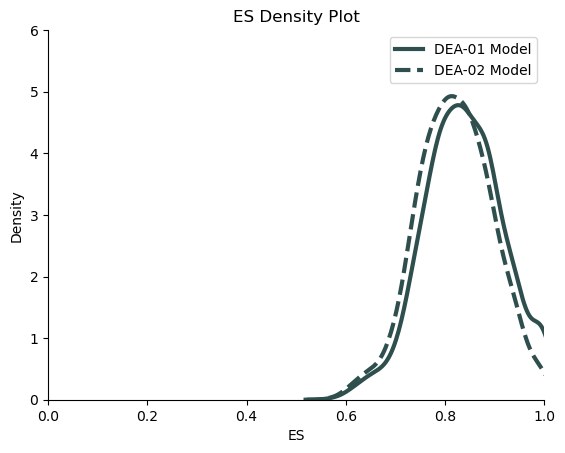

In [157]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for col, label, ls in zip(["Efficiency_Scores_Basic", "Efficiency_Scores_with_ML"], ["DEA-01 Model", "DEA-02 Model"], ["solid", "dashed"]):
    sns.distplot(df_res[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3,
                           'linestyle': ls},
                 label = label,
                color = "darkslategray",
                vertical=False)
    
# Plot formatting
plt.legend(prop={'size': 10})
plt.title('ES Density Plot')
plt.xlabel('ES')
plt.ylabel('Density')

# Set the x-axis range
plt.ylim(0, 6)
plt.xlim(0, 1)
plt.savefig("Viz/Density.png")

In [158]:
pyplot.hist(df_res["Efficiency_Scores_Basic"], alpha=0.5, label='DEA-01 Model')
pyplot.hist(df_res["Efficiency_Scores_with_ML"], alpha=0.5, label='DEA-01 Model')
pyplot.legend(loc='upper right')
pyplot.show()

NameError: name 'pyplot' is not defined